<a href="https://colab.research.google.com/github/ChastityB/Hypothesis-Testing-with-Insurance-Data-Core/blob/main/Hypothesis_Testing_with_Insurance_Data_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hypothesis Testing with Insurance Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQSg4M8Lo3z1C3-9ESRh3xeRnhVeZ_fUu8ts88_Tt3ksCuU8oZtslTumnmzZEZoZaO4N8Fm71nqMmz1/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##Do smokers have higher insurance charges than non-smokers?

State the null and alternative hypothesis

Null Hypothesis: There is no difference in insurance costs between smokers and non smokers

Alternative hypothesis: There is a significant difference in insurance costs between smokers and n on smokers

In [3]:
#separate smoker groups
smoker = df.loc[df['smoker']=='yes', ['smoker', 'charges']]
smoker.head()

,smoker,charges
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768


In [4]:
not_smoker = df.loc[df['smoker']=='no', ['smoker', 'charges']]
not_smoker.head()

,smoker,charges
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520
5,no,3756.62160


In [5]:
#visualization
plot_df = pd.concat([smoker, not_smoker])
plot_df

,smoker,charges
0,yes,16884.9240
11,yes,27808.7251
14,yes,39611.7577
19,yes,36837.4670
23,yes,37701.8768
...,...,...
1332,no,11411.6850
1333,no,10600.5483
1334,no,2205.9808
1335,no,1629.8335


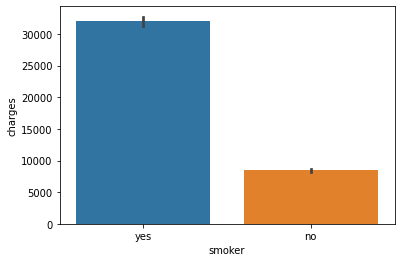

In [6]:
sns.barplot(data=plot_df, x='smoker', y='charges', ci=68)

In [7]:
display(len(smoker), len(not_smoker))

274

1064

In [8]:
#test for outliers
smoker_group = smoker['charges']
not_smoker_group = not_smoker['charges']
smoker_outliers = np.abs(stats.zscore(smoker_group)) > 3
not_smoker_outliers = np.abs(stats.zscore(not_smoker_group)) > 3
display(smoker_outliers.sum(), not_smoker_outliers.sum())

0

24

In [9]:
#remove outliers for non_smoker group
not_smoker_group = not_smoker_group.loc[~not_smoker_outliers]

In [10]:
#test for normality
result = stats.normaltest(smoker_group)
result.pvalue

5.564930630036463e-14

In [11]:
result = stats.normaltest(not_smoker_group)
result.pvalue

2.6945416315543976e-36

We have a large enough group size that we can safely disregard the assumption of normality

In [12]:
#test for equal variance
result = stats.levene(smoker_group, not_smoker_group)
print(result)
if result.pvalue < 0.05:
  print('The groups do NOT have equal variance')
else: 
  print ('The groups DO have equal variance')

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)
The groups do NOT have equal variance


Since the groups do not have equal variance, the welch's t-test will be run instead

In [13]:
#final hypothesis
result = stats.ttest_ind(smoker_group, not_smoker_group, equal_var=False)
print(result)
result.pvalue < 0.05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

The p value was less than 0.05 for the Welch's t test, meaning we reject the null hypothesis and support the alternative hypothesis. There is a significant difference in insurance costs between smokers and non-smokers. 

##Are men more likely to smoke than women?

State the null and alternative hypothesis

Null Hypothesis: There is no difference between men and women who smoke

Alternative hypothesis: There is a significant difference between men and women who smoke

This is categorical, chi-test, and 4 sample groups

In [14]:
#separate smoker groups
male = df.loc[df['sex']=='male', ['sex', 'smoker']]
male.head()

,sex,smoker
1,male,no
2,male,no
3,male,no
4,male,no
8,male,no


In [15]:
#separate smoker groups
female = df.loc[df['sex']=='female', ['sex', 'smoker']]
female.head()

,sex,smoker
0,female,yes
5,female,no
6,female,no
7,female,no
9,female,no


Text(0.5, 1.0, 'Numer of Smokers by Sex')

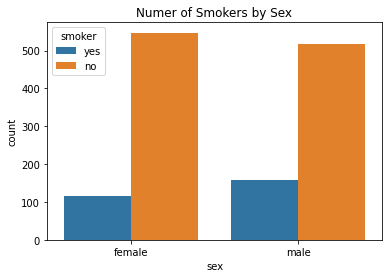

In [16]:
ax = sns.countplot(data = df, x='sex', hue='smoker')
ax.set_title('Numer of Smokers by Sex')

In [17]:
#calculate the contigency table with pd.cross-tab
table = pd.crosstab(df['sex'],df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [18]:
#run the test and save the output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [19]:
#p-value
print(p)
p<0.05

0.006548143503580696


True

The p-value is less than 0.05. We reject the null and support the alternative hypothesis. There is a difference between men and women who smoke. 

##Do different regions have different charges on average?

State the null and alternative hypothesis

Null Hypothesis: There is no difference in charges between regions

Alternative hypothesis: There is a significant difference in charges between regions

This is multiple samples/groups and numerical

In [20]:
#separate into appropriate groups
groups = {}
for region in df['region'].unique():
  temp_df = df.loc[df['region']==region, 'charges']
  groups[region] = temp_df
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

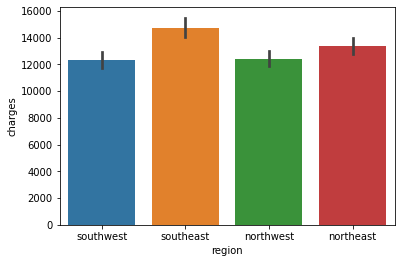

In [21]:
#graph and visualize the results
sns.barplot(data = df, x='region', y='charges', ci=68)

In [22]:
#calculate outliers
for region, data in groups.items():
  outliers = np.abs(stats.zscore(data)) > 3
  print(f'{outliers.sum()} outliers were removed from the {region} group')
  groups[region] = data.loc[~outliers]

8 outliers were removed from the southwest group
2 outliers were removed from the southeast group
7 outliers were removed from the northwest group
4 outliers were removed from the northeast group


In [23]:
#test for normality
norm_results = {}
for i, data in groups.items():
  stat, p = stats.normaltest(data)
  norm_results[i] = {'n':len(data),
                     'p':p}

In [24]:
#display dataframe created from the norm results
pd.DataFrame(norm_results).T

,n,p
southwest,317.0,7.728611e-22
southeast,362.0,1.936990e-13
northwest,318.0,2.940543e-19
northeast,320.0,3.557877e-17


In [25]:
#display dataframe created from norm_results
norm_df = pd.DataFrame(norm_results).T
norm_df['sig?'] = norm_df['p'] < 0.05
norm_df

,n,p,sig?
southwest,317.0,7.728611e-22,True
southeast,362.0,1.936990e-13,True
northwest,318.0,2.940543e-19,True
northeast,320.0,3.557877e-17,True


No need for normality testing as we have large groups. The groups do not come from normal distributions

In [26]:
#equal variance
statistic, pvalue = stats.levene(*groups.values())
print(statistic, pvalue)
if pvalue < 0.05:
  print('The groups do NOT have equal variance')
else: 
  print ('The groups DO have equal variance')

9.518349004554441 3.2035503711783993e-06
The groups do NOT have equal variance


The groups do not have equal variance, therefore we will use the Kruskal test. 

In [27]:
#final hypothesis
statistic, pvalue = stats.kruskal(*groups.values())
print(statistic, pvalue)

6.914045702545643 0.07468847911322242


The p-value is greater than 0.05. We failed to reject the null and support the null hypothesis. There is no significant difference in charges between regions 